In [2]:
# Common packages
import os,sys
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pickle
from importlib import reload  
# Custom packages
#import util

In [3]:
sns.set_context("paper",font_scale=1.5, rc={"lines.linewidth":2})

In [4]:
import networkx as nx
# Process the connected network and return a list of lists where each list contains
# tripBCs that belong to the same clone
with open('220329_tBC_networks_cell_7.pkl', 'rb') as handle:
    net = pickle.load(handle)
coll = net

edges = []
for i in range(len(coll)):
    a = coll[i]
    for j in range(len(coll)):
        if i != j:
            b = coll[j]
            if set(a).intersection(set(b)):
                edges.append((i,j))

G = nx.Graph()
G.add_nodes_from(range(len(coll)))
G.add_edges_from(edges)
final_network = []
for c in nx.connected_components(G):
    combined_lists = [coll[i] for i in c]
    flat_list = [item for sublist in combined_lists for item in sublist]
    final_network.append(list(set(flat_list)))
# connected trip is a list of lists contains clones with more than 1 tripBC
connected_trips = [a for a in final_network if len(a) > 1]

In [5]:
#Save the connected TRIP bcs
# with open('220329_connected_trips.pkl', 'wb') as handle:
#     pickle.dump(connected_trips, handle, protocol=pickle.HIGHEST_PROTOCOL)

### Process the validated data

In [6]:
# Read in a tsv file of manually linked clones
manual_clones = pd.read_csv('220308_potential_manual_clones.tsv', sep='\t')
# process the file to create a dict of lists 
manual_clones_list = []
# Clone names
clone_names = list(set(manual_clones['clone']))
# Get the clones
for c in clone_names:
    trip_BCs = manual_clones[manual_clones['clone'] == c]['tBC'].tolist()
    trip_BCs.remove('AGGTTGCACGACAATC')
    manual_clones_list.append(trip_BCs)

In [7]:
# here I want to return the manually validated trip Clones and tripBCs
total_tested = len(manual_clones_list)
# Check if any of the called clones are uniquely connected to a manually validated
validated_clone_dict = {}
counter = 0
for clone in connected_trips:
    temp_holder = []
    for trip_BC in clone:
        matched_clone = [list for list in manual_clones_list if trip_BC in list]
        if len(matched_clone) == 1:
            if matched_clone[0] not in temp_holder:
                temp_holder.append(matched_clone[0])
    counter += len(temp_holder)
    if len(temp_holder) != 0:
        matched_barcodes = [bc for sublist in temp_holder for bc in sublist]
        matched_bcs = list(set(clone).intersection(set(matched_barcodes)))
        print(f'the length of the clone is {len(clone)}, the percentage matched is {len(matched_bcs)/len(clone)}')
        validated_clone_dict[tuple(clone)]=matched_bcs
print(f'{counter} out of {total_tested} are found with a friend')

the length of the clone is 14, the percentage matched is 0.07142857142857142
the length of the clone is 16, the percentage matched is 0.5625
the length of the clone is 6, the percentage matched is 0.5
the length of the clone is 11, the percentage matched is 0.09090909090909091
the length of the clone is 2, the percentage matched is 1.0
the length of the clone is 7, the percentage matched is 1.0
the length of the clone is 15, the percentage matched is 0.5333333333333333
the length of the clone is 9, the percentage matched is 0.4444444444444444
the length of the clone is 3, the percentage matched is 0.3333333333333333
the length of the clone is 5, the percentage matched is 1.0
the length of the clone is 18, the percentage matched is 0.7222222222222222
the length of the clone is 16, the percentage matched is 1.0
the length of the clone is 2, the percentage matched is 1.0
the length of the clone is 2, the percentage matched is 1.0
the length of the clone is 10, the percentage matched is 1.

In [6]:
# for clone in connected_trip:
#     temp_holder = []
#     for trip_BC in clone:
#         matched_clone = [list for list in manual_clones_list if trip_BC in list]
#         if len(matched_clone) == 1:
#             if matched_clone[0] not in temp_holder:
#                 temp_holder.append(matched_clone[0])
#         elif len(matched_clone) > 1: 
#             print('non-unique clone multiple match')
#             print(trip_BC, 'in ',matched_clone)
#     if len(temp_holder) > 1:
#         print('non-unique clone')
#         print(temp_holder)

### Making a network based on the tripBCs that are connected

In [7]:
from pyvis.network import Network
from itertools import combinations
nt = Network(notebook=True)
# Flatten the list of barcodes that are used
nodes = [item for sublist in connected_trips for item in sublist]
validated_nodes = [item for sublist in list(validated_clone_dict.values()) for item in sublist]
# Get all tripBCs are manually validated
for node in nodes:
    if node in validated_nodes:
        nt.add_node(node, size = 20, color='red', group = 1)
    if node not in validated_nodes:
        nt.add_node(node, size = 10, group =2)
for subgraph in connected_trips:
    edges_sub_graph = list(combinations(subgraph, 2))
    for edge in edges_sub_graph:
        if (edge[0] in validated_nodes) or (edge[1] in validated_nodes):
            nt.add_edge(edge[0],edge[1], weight = 5)
        else:
            nt.add_edge(edge[0],edge[1], weight = 2)

In [8]:
# First we make a mapping system
from itertools import combinations
nodes = [item for sublist in connected_trips for item in sublist]
edges = []
for subgraph in connected_trips:
    edges_sub_graph = list(combinations(subgraph, 2))
    edges.extend(edges_sub_graph)


In [9]:
trip_nx = nx.Graph()
trip_nx.add_nodes_from(nodes)
trip_nx.add_edges_from(edges)

### Make graph

In [10]:
nt.from_nx(trip_nx)
# nt.enable_physics(True)
#nt.show_buttons(filter_=True)
nt.show('nx.html')
#

In [15]:
integration_length = [len(x) for x in final_network]

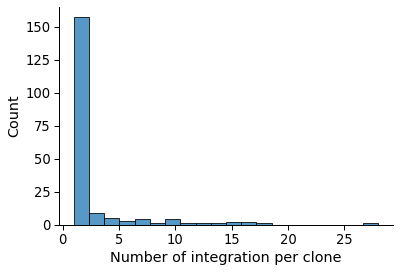

In [19]:
sns.histplot(integration_length, bins = 20)
sns.despine()
plt.xlabel('Number of integration per clone')
plt.savefig('220406_num_integration_per_clone.pdf', dpi = 300 )

In [14]:
integration_length

[16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16]